# Intro to Time Series Forecasting
---

## Introduction
In this notebook, we will learn how to work with and predict time series. Time series are a collection of time-dependent data points. That means that each data point is assigned to a specific timestamp. Ideally, these data points are in chronological order and in contant time intervals (e.g. every minute or everyday). The time series forecasting problem analyzes patterns in the past data to make predictions about the future. The most popular example is probably stock price prediction. Other examples are sales of seasonal clothing or weather forecasts. In contrast to regression problems, time series are time-dependent and show specific characteristics, such as trend and seasonality.

In [3]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
     ---------------------------------------- 8.0/8.0 MB 21.2 MB/s eta 0:00:00
  Using cached fonttools-4.53.1-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached kiwisolver-1.4.5-cp310-cp310-win_amd64.whl (56 kB)
  Using cached contourpy-1.2.1-cp310-cp310-win_amd64.whl (187 kB)
  Using cached pillow-10.4.0-cp310-cp310-win_amd64.whl (2.6 MB)
  Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached scikit_learn-1.5.1-cp310-cp310-win_amd64.whl (11.0 MB)
  Using cached scipy-1.14.0-cp310-cp310-win_amd64.whl (44.8 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

df = pd.read_csv("Aquifer_Petrignano.csv")

### Simplifications for the sake of the tutorial ###
# Drop data before 2009 for the purpose of this tutorial
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)
# Drop one of the target columns, so we can focus on only one target
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

# Simplify column names
df.columns = ['Date', 'Rainfall', 'Depth_to_Groundwater', 'Temperature', 'Drainage_Volume', 'River_Hydrometry']

targets = ['Depth_to_Groundwater']
features = [feature for feature in df.columns if feature not in targets]
df.head()

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


In [7]:
!pip install Jinja2

  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached MarkupSafe-2.1.5-cp310-cp310-win_amd64.whl (17 kB)



[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
from datetime import datetime, date 

df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')
df.head().style.set_properties(subset=['Date'], **{'background-color': 'dodgerblue'})

,Date,Rainfall,Depth_to_Groundwater,Temperature,Drainage_Volume,River_Hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


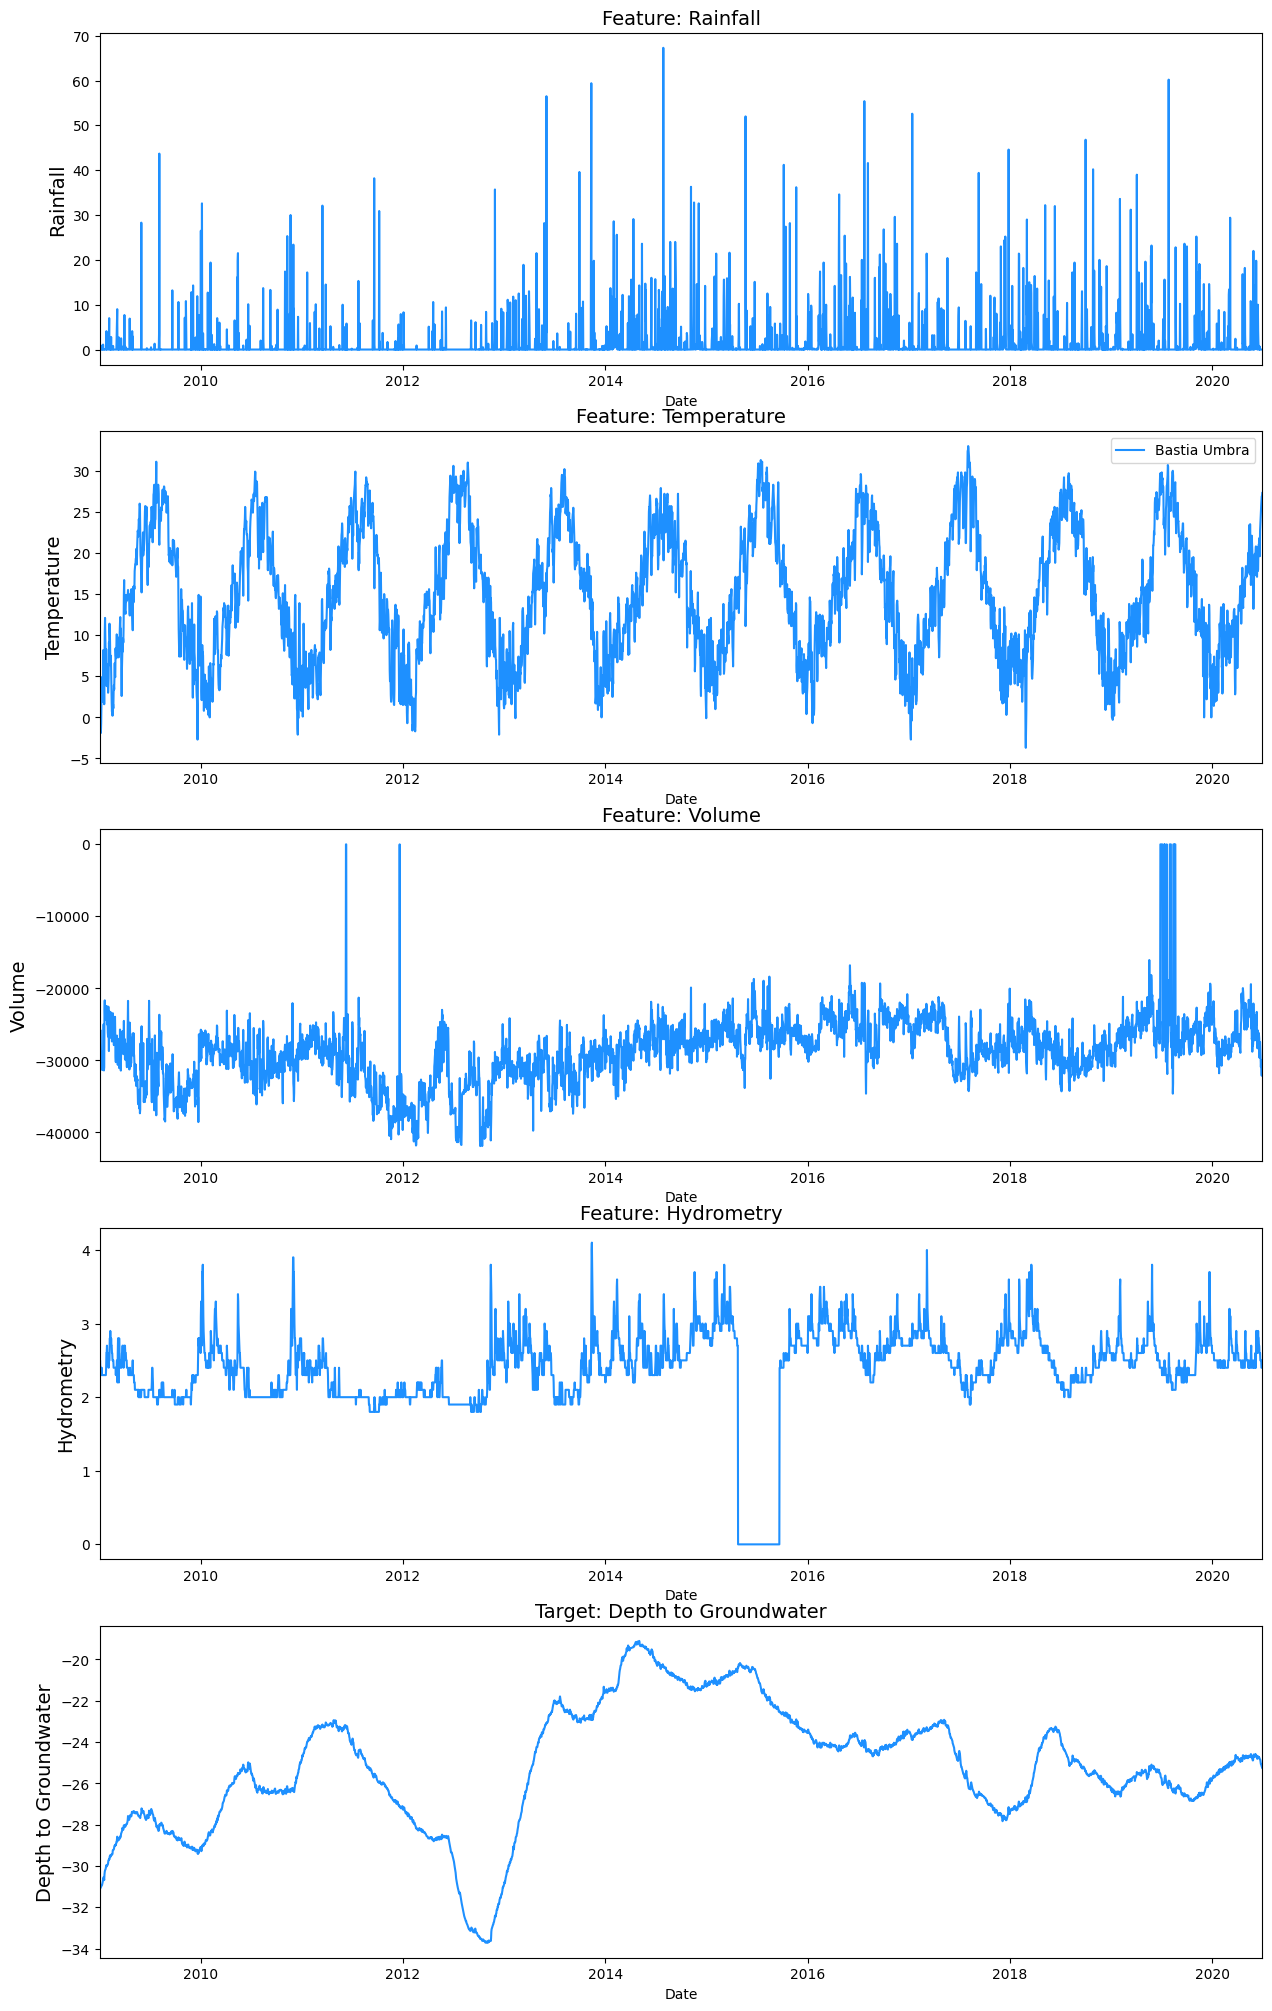

In [9]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

sns.lineplot(x=df.Date, y=df.Rainfall.fillna(np.inf), ax=ax[0], color='dodgerblue')
ax[0].set_title('Feature: Rainfall', fontsize=14)
ax[0].set_ylabel(ylabel='Rainfall', fontsize=14)


sns.lineplot(x=df.Date, y=df.Temperature.fillna(np.inf), ax=ax[1], color='dodgerblue',label='Bastia Umbra')
ax[1].set_title('Feature: Temperature', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)


sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue')
ax[2].set_title('Feature: Volume', fontsize=14)
ax[2].set_ylabel(ylabel='Volume', fontsize=14)


sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[3], color='dodgerblue')
ax[3].set_title('Feature: Hydrometry', fontsize=14)
ax[3].set_ylabel(ylabel='Hydrometry', fontsize=14)


sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.fillna(np.inf), ax=ax[4], color='dodgerblue')
ax[4].set_title('Target: Depth to Groundwater', fontsize=14)
ax[4].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(5):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

In [10]:
# Sort values by timestamp (not necessary in this case)
df = df.sort_values(by='Date')

# Check time intervals
df['Time_Interval'] = df.Date - df.Date.shift(1)

df[['Date', 'Time_Interval']].head()

,Date,Time_Interval
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [11]:
print(f"{df['Time_Interval'].value_counts()}")
df = df.drop('Time_Interval', axis=1)

Time_Interval
1 days    4198
Name: count, dtype: int64


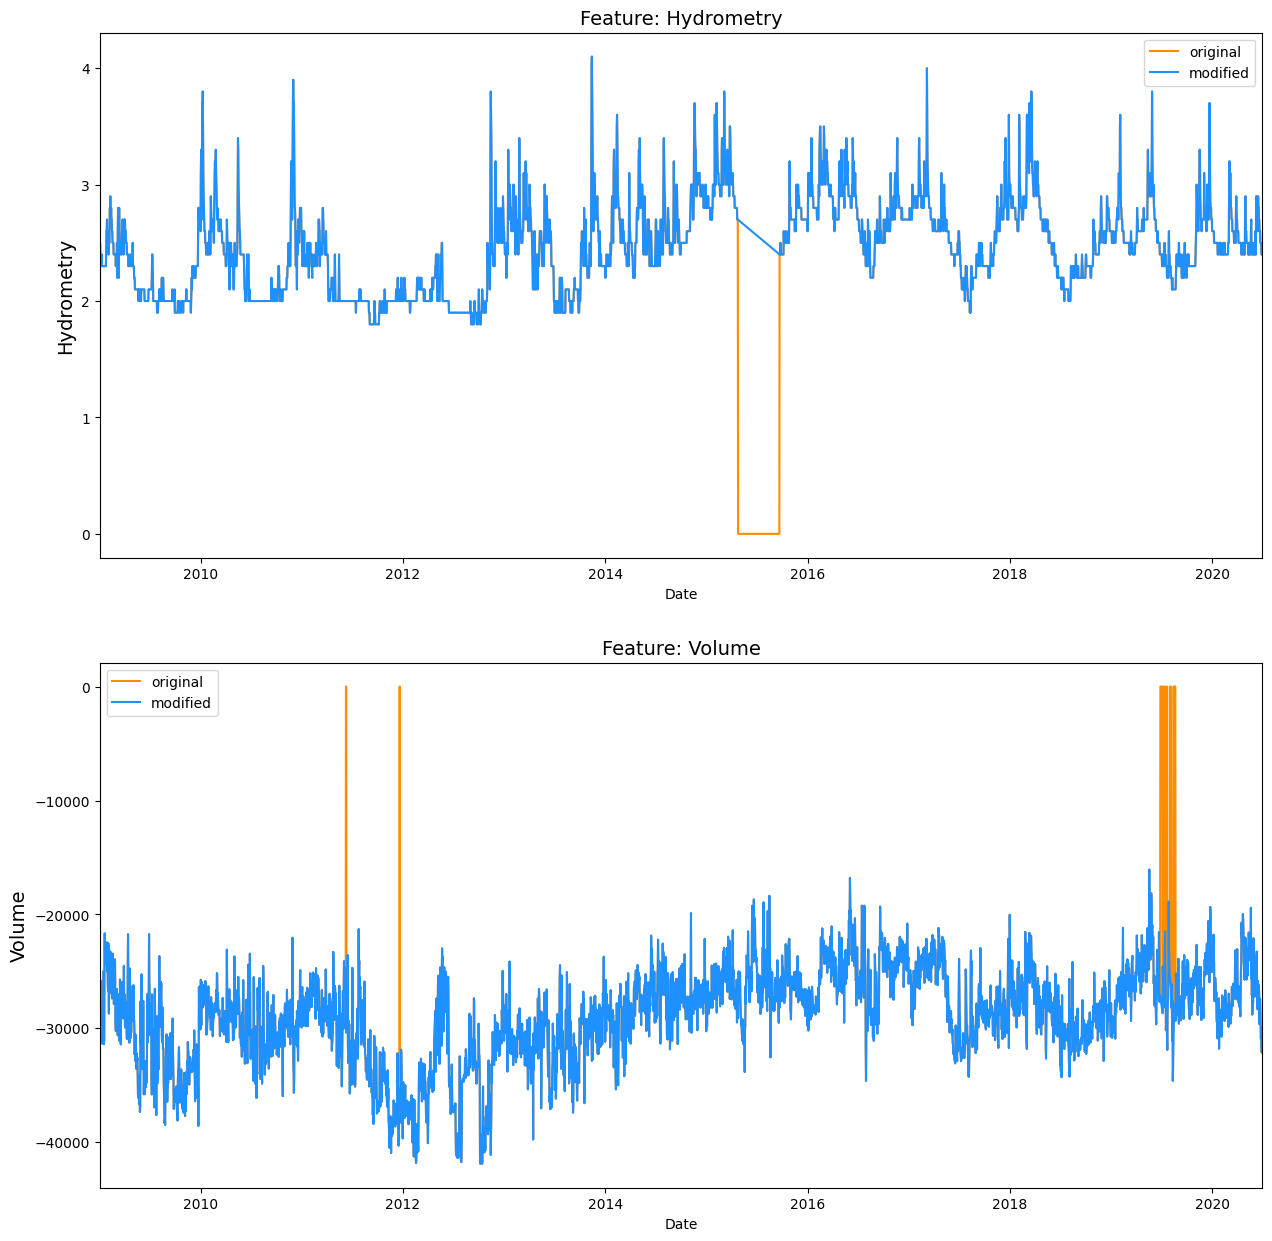

In [12]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
old = df.River_Hydrometry.copy()
df['River_Hydrometry'] = np.where((df.River_Hydrometry == 0),np.nan, df.River_Hydrometry)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[0], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)

old = df.Drainage_Volume.copy()
df['Drainage_Volume'] = np.where((df.Drainage_Volume == 0),np.nan, df.Drainage_Volume)

sns.lineplot(x=df.Date, y=old.fillna(np.inf), ax=ax[1], color='darkorange', label = 'original')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'modified')
ax[1].set_title('Feature: Volume', fontsize=14)
ax[1].set_ylabel(ylabel='Volume', fontsize=14)


for i in range(2):
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.show()

AttributeError: 'YTick' object has no attribute 'label'

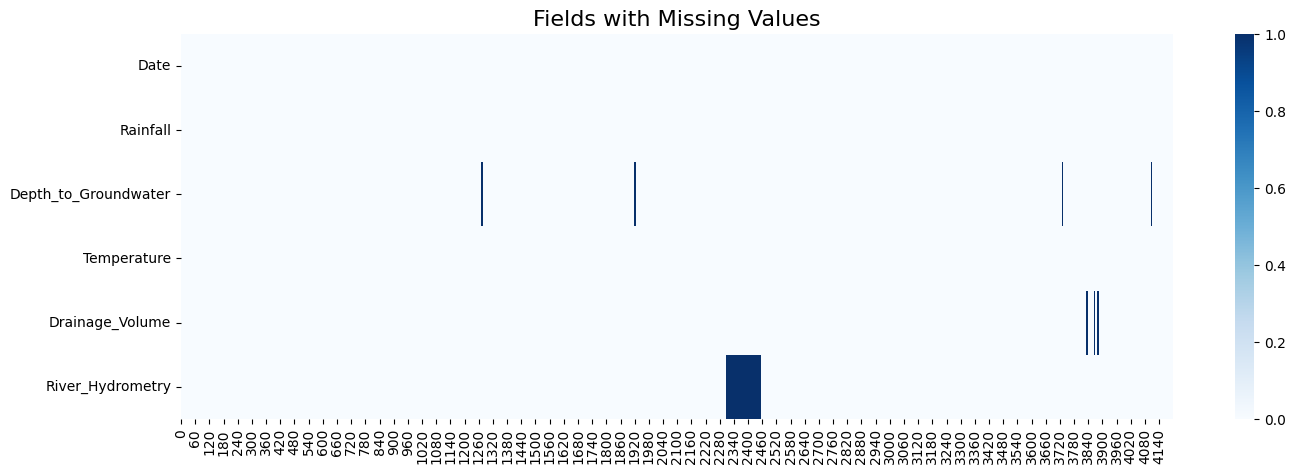

In [13]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))
sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Fields with Missing Values', fontsize=16)
#for tick in ax.xaxis.get_major_ticks():
#    tick.label.set_fontsize(14) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()

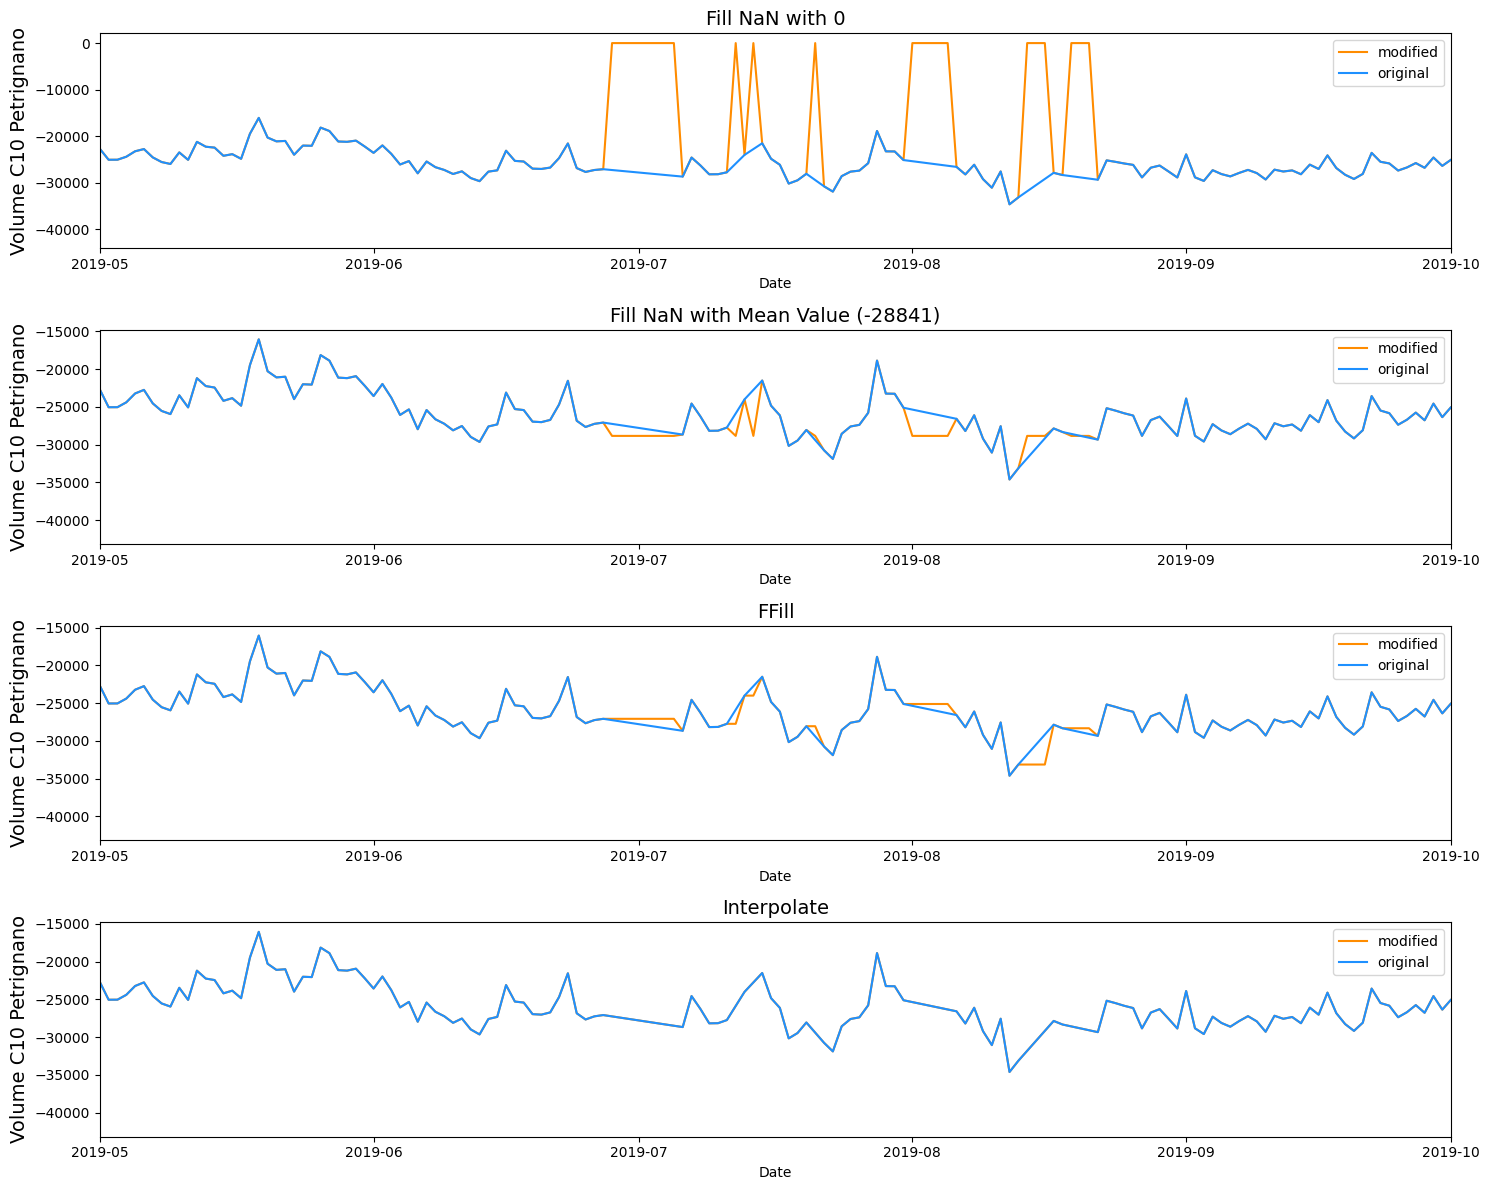

In [14]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

mean_val = df.Drainage_Volume.mean()
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(mean_val), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_val:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume.interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)

for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

In [15]:
df['Drainage_Volume'] = df['Drainage_Volume'].interpolate()
df['River_Hydrometry'] = df['River_Hydrometry'].interpolate()
df['Depth_to_Groundwater'] = df['Depth_to_Groundwater'].interpolate()

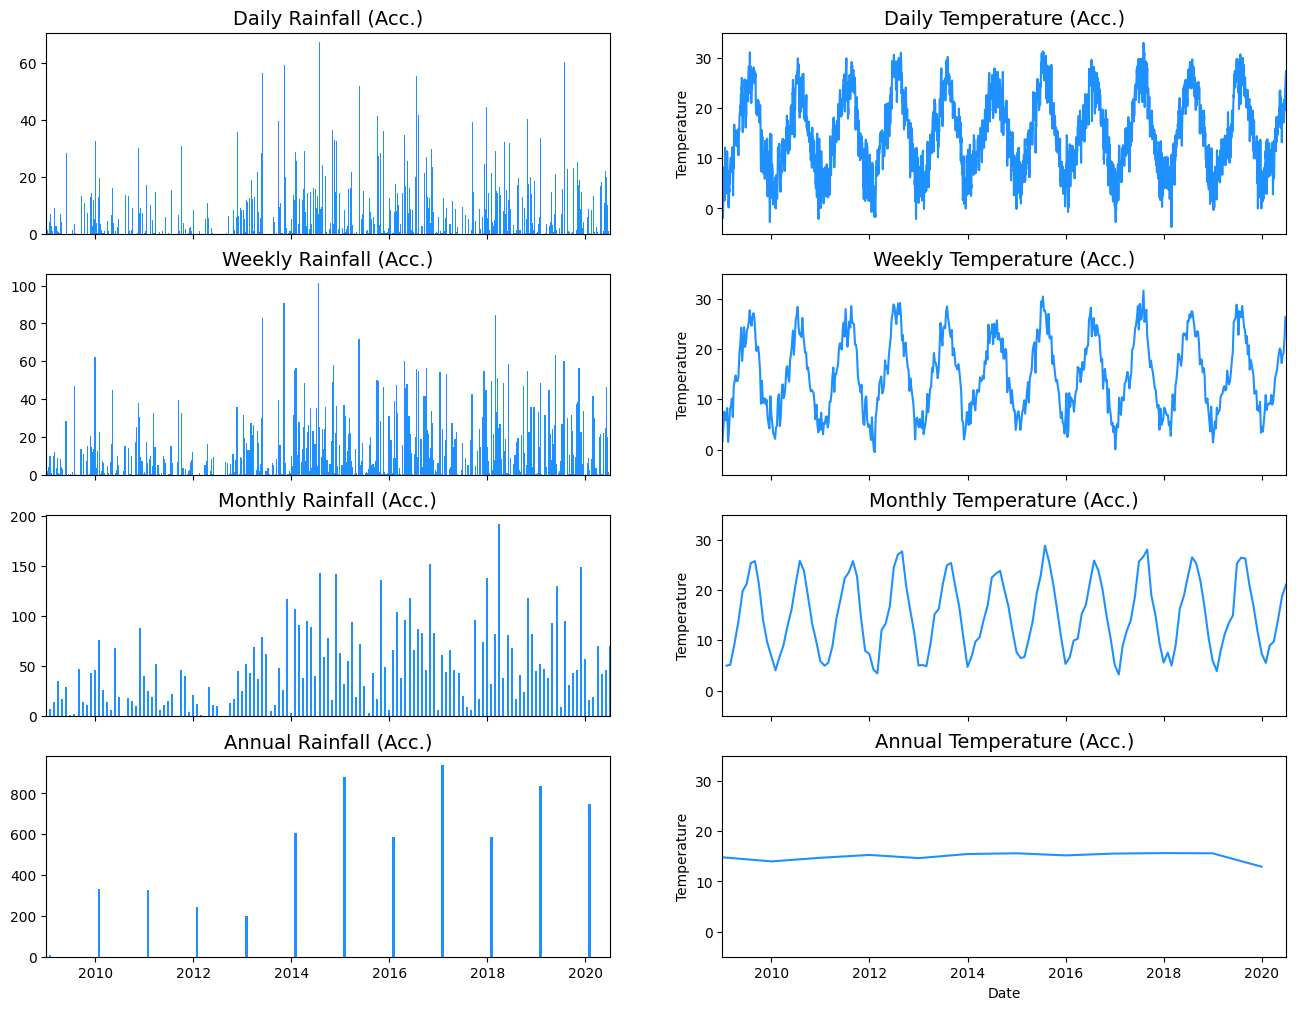

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16,12))

# Plotting Rainfall
ax[0, 0].bar(df.Date, df.Rainfall, width=5, color='dodgerblue')
ax[0, 0].set_title('Daily Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('7D', on='Date').sum().reset_index(drop=False)
ax[1, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=10, color='dodgerblue')
ax[1, 0].set_title('Weekly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('M', on='Date').sum().reset_index(drop=False)
ax[2, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=15, color='dodgerblue')
ax[2, 0].set_title('Monthly Rainfall (Acc.)', fontsize=14)

resampled_df = df[['Date','Rainfall']].resample('12M', on='Date').sum().reset_index(drop=False)
ax[3, 0].bar(resampled_df.Date, resampled_df.Rainfall, width=20, color='dodgerblue')
ax[3, 0].set_title('Annual Rainfall (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Plotting Temperature
sns.lineplot(x=df.Date, y=df.Temperature, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('7D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df.Date, y=resampled_df.Temperature, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('M', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df.Date, y=resampled_df.Temperature, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

resampled_df = df[['Date','Temperature']].resample('365D', on='Date').mean().reset_index(drop=False)
sns.lineplot(x=resampled_df.Date, y=resampled_df.Temperature, color='dodgerblue', ax=ax[3, 1])
ax[3, 1].set_title('Annual Temperature (Acc.)', fontsize=14)

for i in range(4):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_ylim([-5, 35])

plt.show()


In [18]:
df_downsampled = df[['Date',
                     'Depth_to_Groundwater', 
                     'Temperature',
                     'Drainage_Volume', 
                     'River_Hydrometry'
                    ]].resample('7D', on='Date').mean().reset_index(drop=False)

df_downsampled['Rainfall'] = df[['Date',
                                 'Rainfall'
                                ]].resample('7D', on='Date').sum().reset_index(drop=False)[['Rainfall']]

df = df_downsampled

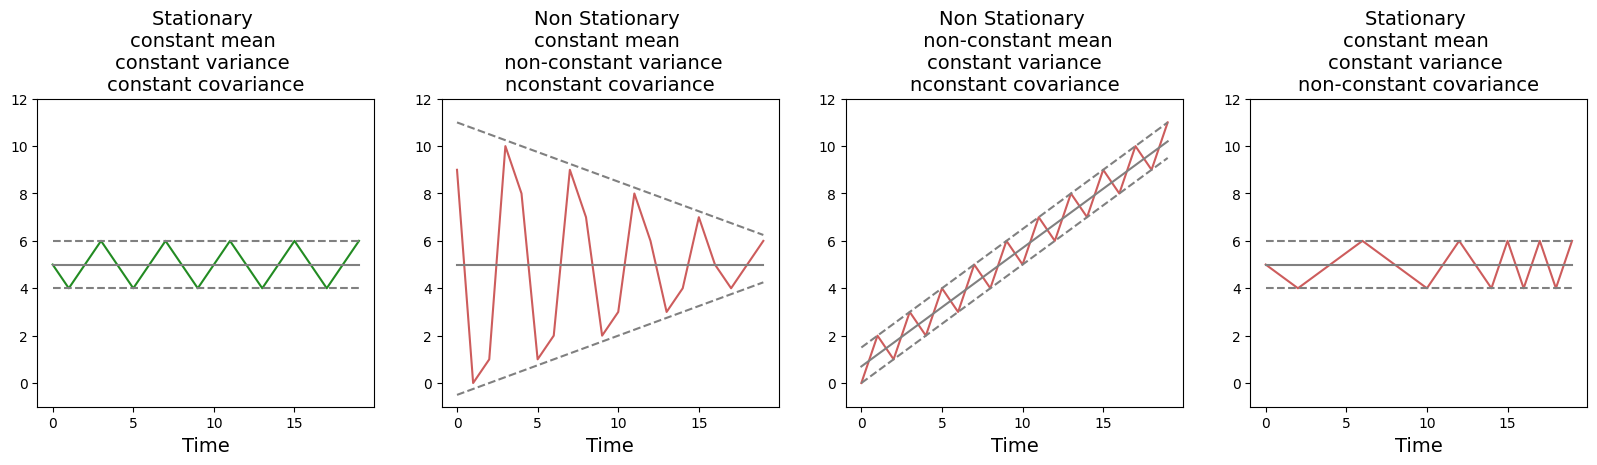

In [19]:
t = np.linspace(0, 19, 20)

fig, ax = plt.subplots(ncols=4, nrows=1, figsize=(20,4))
stationary = [5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6, 5, 4, 5, 6,]
sns.lineplot(x=t, y=stationary, ax=ax[0], color='forestgreen')
sns.lineplot(x=t, y=5, ax=ax[0], color='grey')
sns.lineplot(x=t, y=6, ax=ax[0], color='grey')
sns.lineplot(x=t, y=4, ax=ax[0], color='grey')
ax[0].lines[2].set_linestyle("--")
ax[0].lines[3].set_linestyle("--")
ax[0].set_title(f'Stationary \nconstant mean \nconstant variance \nconstant covariance', fontsize=14)

nonstationary1 = [ 9, 0, 1, 10, 8, 1, 2, 9, 7, 2, 3, 8, 6, 3, 4, 7, 5, 4, 5, 6]
sns.lineplot(x=t, y=nonstationary1, ax=ax[1], color='indianred' )
sns.lineplot(x=t, y=5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*0.25-0.5, ax=ax[1], color='grey')
sns.lineplot(x=t, y=t*(-0.25)+11, ax=ax[1], color='grey')
ax[1].lines[2].set_linestyle("--")
ax[1].lines[3].set_linestyle("--")
ax[1].set_title(f'Non Stationary \nconstant mean \n non-constant variance\nnconstant covariance', fontsize=14)

nonstationary2 = [0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5, 7, 6, 8, 7, 9, 8, 10, 9, 11,]
sns.lineplot(x=t, y=nonstationary2, ax=ax[2], color='indianred' )
sns.lineplot(x=t, y=t*0.5+0.7, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5, ax=ax[2], color='grey')
sns.lineplot(x=t, y=t*0.5+1.5, ax=ax[2], color='grey')
ax[2].lines[2].set_linestyle("--")
ax[2].lines[3].set_linestyle("--")
ax[2].set_title(f'Non Stationary \n non-constant mean\nconstant variance\nnconstant covariance', fontsize=14)

nonstationary3 = [5, 4.5, 4, 4.5, 5, 5.5, 6, 5.5, 5, 4.5, 4, 5, 6, 5, 4, 6, 4, 6, 4, 6,]
sns.lineplot(x=t, y=nonstationary3, ax=ax[3], color='indianred')
sns.lineplot(x=t, y=5, ax=ax[3], color='grey')
sns.lineplot(x=t, y=6, ax=ax[3], color='grey')
sns.lineplot(x=t, y=4, ax=ax[3], color='grey')
ax[3].lines[2].set_linestyle("--")
ax[3].lines[3].set_linestyle("--")
ax[3].set_title(f'Stationary \nconstant mean \nconstant variance \nnon-constant covariance', fontsize=14)

for i in range(4):
    ax[i].set_ylim([-1, 12])
    ax[i].set_xlabel('Time', fontsize=14)

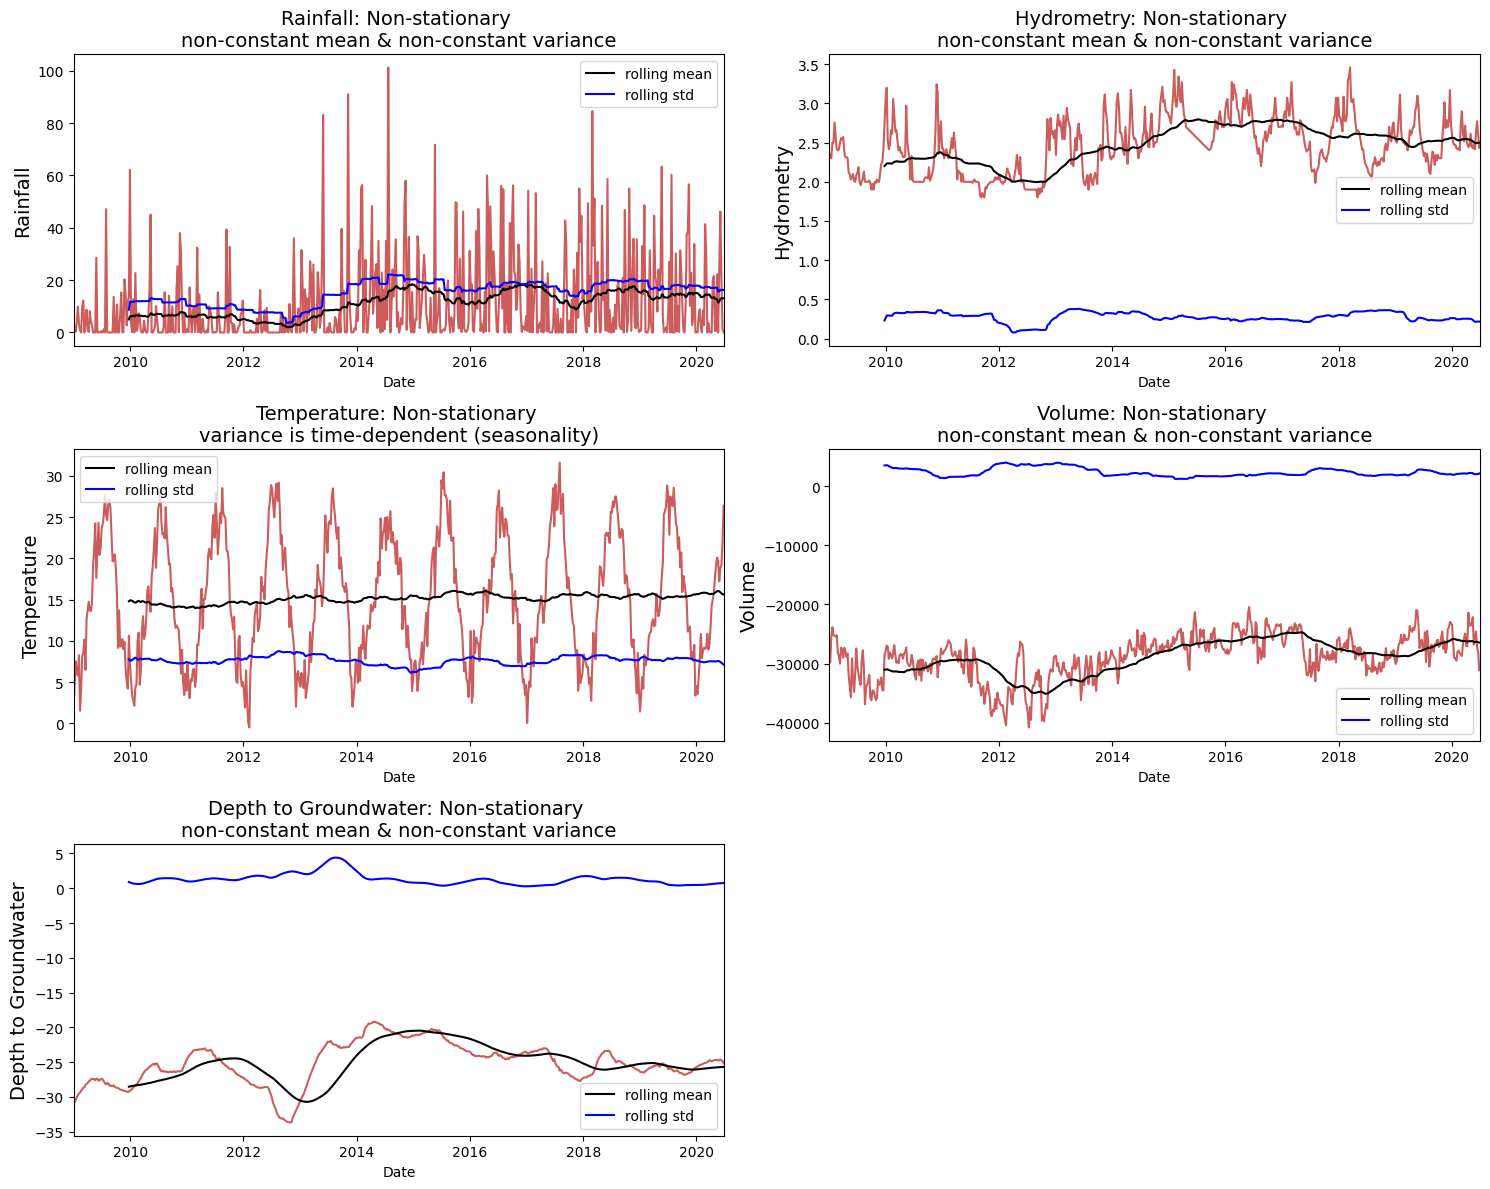

In [20]:
rolling_window = 52
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

sns.lineplot(x=df.Date, y=df.Rainfall, ax=ax[0, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).mean(), ax=ax[0, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Rainfall.rolling(rolling_window).std(), ax=ax[0, 0], color='blue', label='rolling std')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.lineplot(x=df.Date, y=df.Temperature, ax=ax[1, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).mean(), ax=ax[1, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Temperature.rolling(rolling_window).std(), ax=ax[1, 0], color='blue', label='rolling std')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.lineplot(x=df.Date, y=df.River_Hydrometry, ax=ax[0, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).mean(), ax=ax[0, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.River_Hydrometry.rolling(rolling_window).std(), ax=ax[0, 1], color='blue', label='rolling std')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.lineplot(x=df.Date, y=df.Drainage_Volume, ax=ax[1, 1], color='indianred')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).mean(), ax=ax[1, 1], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Drainage_Volume.rolling(rolling_window).std(), ax=ax[1, 1], color='blue', label='rolling std')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater, ax=ax[2, 0], color='indianred')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).mean(), ax=ax[2, 0], color='black', label='rolling mean')
sns.lineplot(x=df.Date, y=df.Depth_to_Groundwater.rolling(rolling_window).std(), ax=ax[2, 0], color='blue', label='rolling std')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)


for i in range(3):
    ax[i,0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i,1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

In [25]:
num_partitions = 2
partition_length = int(len(df) / num_partitions)

# Assuming 'Date' is the datetime column
numeric_columns = df.select_dtypes(include=['number']).columns

partition1_mean = df.head(partition_length)[numeric_columns].mean()
partition1_var = df.head(partition_length)[numeric_columns].var()
partition2_mean = df.tail(partition_length)[numeric_columns].mean()
partition2_var = df.tail(partition_length)[numeric_columns].var()


In [26]:
stationarity_test = pd.concat([partition1_mean, partition2_mean, partition1_var, partition2_var], axis=1)
stationarity_test.columns = ['Partition 1 Mean', 'Partition 2 Mean', 'Partition 1 Variance', 'Partition 2 Variance']

def highlight_greater(x):
    temp = x.copy()
    temp = temp.round(0).astype(int)
    m1 = (temp['Partition 1 Mean'] == temp['Partition 2 Mean'])
    m2 = (temp['Partition 1 Variance'] == temp['Partition 2 Variance'])
    m3 = (temp['Partition 1 Mean'] < temp['Partition 2 Mean']+3) & (temp['Partition 1 Mean'] > temp['Partition 2 Mean']-3)
    m4 = (temp['Partition 1 Variance'] < temp['Partition 2 Variance']+3) & (temp['Partition 1 Variance'] > temp['Partition 2 Variance']-3)

    df1 = pd.DataFrame('background-color: ', index=x.index, columns=x.columns)
    #rewrite values by boolean masks
    df1['Partition 1 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(~m1, 'background-color: {}'.format('salmon'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m3, 'background-color: {}'.format('gold'), df1['Partition 2 Mean'])
    df1['Partition 1 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Mean'])
    df1['Partition 2 Mean'] = np.where(m1, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Mean'])

    df1['Partition 1 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(~m2, 'background-color: {}'.format('salmon'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m4, 'background-color: {}'.format('gold'), df1['Partition 2 Variance'])
    df1['Partition 1 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 1 Variance'])
    df1['Partition 2 Variance'] = np.where(m2, 'background-color: {}'.format('mediumseagreen'), df1['Partition 2 Variance'])

    return df1


stationarity_test.style.apply(highlight_greater, axis=None).format("{:20,.0f}")

,Partition 1 Mean,Partition 2 Mean,Partition 1 Variance,Partition 2 Variance
Depth_to_Groundwater,-26,-24,13,4
Temperature,15,15,58,56
Drainage_Volume,"-30,989","-26,684","12,053,921","5,955,484"
River_Hydrometry,2,3,0,0
Rainfall,8,14,197,306


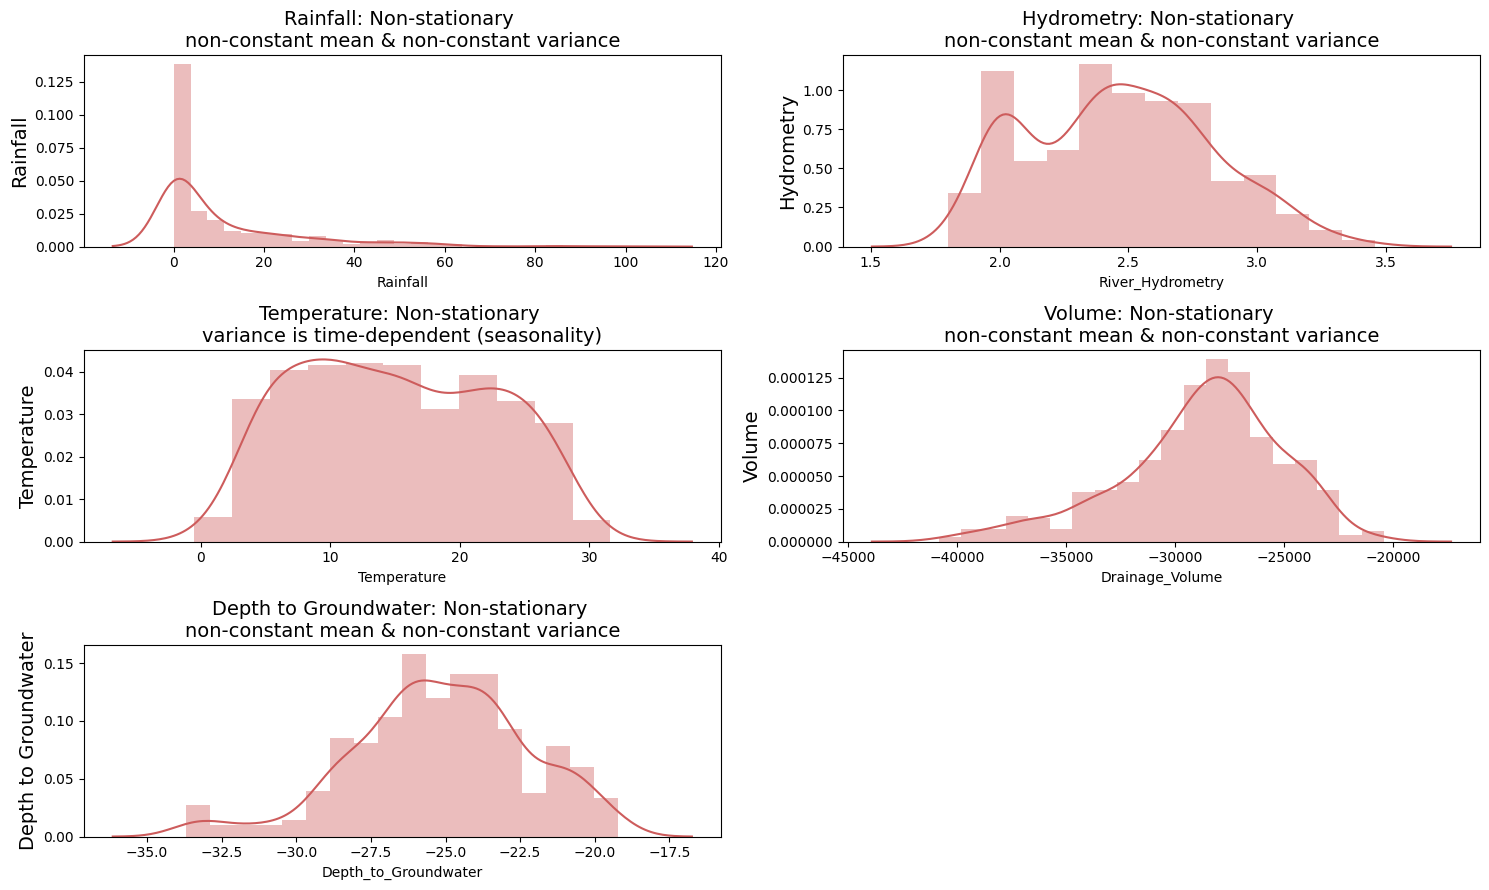

In [27]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

sns.distplot(df.Rainfall.fillna(np.inf), ax=ax[0, 0], color='indianred')
ax[0, 0].set_title('Rainfall: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 0].set_ylabel(ylabel='Rainfall', fontsize=14)

sns.distplot(df.Temperature.fillna(np.inf), ax=ax[1, 0], color='indianred')
ax[1, 0].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1, 0].set_ylabel(ylabel='Temperature', fontsize=14)

sns.distplot(df.River_Hydrometry.fillna(np.inf), ax=ax[0, 1], color='indianred')
ax[0, 1].set_title('Hydrometry: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0, 1].set_ylabel(ylabel='Hydrometry', fontsize=14)

sns.distplot(df.Drainage_Volume.fillna(np.inf), ax=ax[1, 1], color='indianred')
ax[1, 1].set_title('Volume: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[1, 1].set_ylabel(ylabel='Volume', fontsize=14)

sns.distplot(df.Depth_to_Groundwater.fillna(np.inf), ax=ax[2, 0], color='indianred')
ax[2, 0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[2, 0].set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()